In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from vocab import Vocab
from collections import Counter
from tqdm import tqdm
import pickle
import nltk
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from sklearn.model_selection import train_test_split
import time
import random
import math
from data_utils import tokenize
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot(epoch, step, train_losses):
    clear_output()
    plt.title(f'Epochs {epoch}, step {step}')
    plt.plot(train_losses)
    plt.show()

In [3]:
data  = pd.read_csv('data/transcriptions/train.csv')

In [4]:
data.head()

,Id,Word,Transcription
0,1,KNOXVILLE,N AA K S V IH L
1,2,MOVIEGOING,M UW V IY G OW IH NG
2,3,PHOTOSYNTHESIS,F OW T OW S IH N TH AH S IH S
3,4,DELIO,D EY L IY OW
4,5,SWIVELED,S W IH V AH L D


In [5]:
def tokenize(word):
    return [char for char in word if char!=' ']

In [6]:
data['Word'] = data['Word'].apply(lambda row: tokenize(row) if type(row)!= float else 0)

In [7]:
data = data[(data['Word']!=0)]

In [8]:
data['Transcription'] = data['Transcription'].apply(lambda row: tokenize(row))

In [9]:
for idx, i in enumerate(data['Word']):
    for j in i: 
        if type(j) != str:
            print(idx)

In [10]:
class TranscriptionsDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.t_vocab = pickle.load(open('transcription_vocab.pickle', 'rb'))
        self.w_vocab = pickle.load(open('word_vocab.pickle', 'rb'))
        self.word = self.data['Word'].values
        self.transcription = self.data['Transcription'].values
    
    def __getitem__(self, idx):
        word = self.word[idx]
        transcription = self.transcription[idx]
        word  = self.w_vocab.sent2idx(word)
        transcription = self.t_vocab.sent2idx(transcription)
        sample = {'word': word, 'transcription': transcription}
        return sample
    
    def __len__(self):
        return len(self.data)
    
    def collate_fn(self, dicts): 
        pad_token = self.t_vocab.token2idx('<pad>')
        sos_token = self.t_vocab.token2idx('<sos>')
        eos_token = self.t_vocab.token2idx('<eos>')
        words_padded = []
        corpus_size = len(dicts)
        len_words_list = [len(d['word']) for d in dicts]
        words_list = [d['word'] for d in dicts]
        
        len_transcriptions_list = [len(d['transcription']) for d in dicts]
        transcriptions = [i['transcription'] for i in dicts]
       
        sorted_len_words, sorted_words, sorted_len_transcriptions, sorted_transcriptions = list(zip(*sorted(zip(
            len_words_list, words_list, len_transcriptions_list, transcriptions),key=lambda x: x[0] ,reverse=True)))      
        max_lens_word = max(sorted_len_words)
        max_lens_transcription = max(sorted_len_transcriptions)

        
        words_padded = [sorted_words[i] + [pad_token] * (max_lens_word - sorted_len_words[i]) for i in range(corpus_size)]
        sos_transcriptions_padded = [[sos_token] + sorted_transcriptions[i] + [pad_token] * (max_lens_transcription - sorted_len_transcriptions[i]) for i in range(corpus_size)]
        eos_transcriptions_padded = [sorted_transcriptions[i] + [eos_token] + [pad_token] * (max_lens_transcription - sorted_len_transcriptions[i]) for i in range(corpus_size)]
        words_padded = torch.LongTensor(words_padded)
        
        sos_transcriptions_padded = torch.LongTensor(sos_transcriptions_padded)
        eos_transcriptions_padded = torch.LongTensor(eos_transcriptions_padded)
        
        return (words_padded, sos_transcriptions_padded, eos_transcriptions_padded)

In [11]:
X_train, X_test = train_test_split(data, test_size=0.33, random_state=42)

In [12]:
train_dataset = TranscriptionsDataset(X_train)
test_dataset = TranscriptionsDataset(X_test)

In [13]:
w_vocab = pickle.load(open('word_vocab.pickle', 'rb'))
t_vocab = pickle.load(open('transcription_vocab.pickle', 'rb'))

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=32,
                            shuffle=True, collate_fn=train_dataset.collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32,
                            shuffle=False, collate_fn=test_dataset.collate_fn)

In [15]:
len_words_list = [5, 5, 6]
words_list =  [[20, 21, 8, 11, 23], [12, 24, 10, 10, 17], [15, 9, 26, 4, 6, 4]]
len_transcriptions_list = [6, 5, 8]
transcriptions = [[20, 11, 18, 8, 11, 23], [12, 21, 15, 10, 29], [15, 15, 9, 15, 4, 21, 15, 4]]

In [16]:
class Encoder(nn.Module):
    def __init__(self,input_dim, enc_embed_dim, hidden_dim, n_layers):
        super(Encoder,self).__init__()
        self.input_dim = input_dim
        self.enc_embed_dim = enc_embed_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, enc_embed_dim)
        self.LSTM = nn.LSTM(enc_embed_dim, hidden_dim, n_layers, batch_first=True)
    
    def forward(self,input_seq):
        embedded = self.embedding(input_seq) # input_seq = (5, seq_len) embedded = (5, seq_len, 256)
        outputs, (hidden, cell) = self.LSTM(embedded) # outputs = (5, seq_len, 256)
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, dec_embed_dim, hidden_dim, n_layers):
        super(Decoder,self).__init__()
        self.output_dim = output_dim
        self.dec_embed_dim = dec_embed_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        #layers
        self.embedding = nn.Embedding(output_dim, dec_embed_dim)
        self.LSTM = nn.LSTM(dec_embed_dim, hidden_dim, n_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self,input_step, hidden, cell):
        #input_step = input_step.unsqueeze(1)
        embedded = self.embedding(input_step) # embedded = (32, seq_len, 256)
        output, (hidden, cell) = self.LSTM(embedded, (hidden, cell)) # output = (1, 1, 64)
        prediction = self.out(output.squeeze(1)) # prediction = (1, 56)
      
        return prediction, hidden, cell

In [17]:
INPUT_DIM = len(w_vocab)
OUTPUT_DIM = len(t_vocab)
ENC_EMB_DIM = 100
DEC_EMB_DIM = 100
HID_DIM = 64
N_LAYERS = 1

In [18]:
OUTPUT_DIM

56

In [19]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS).to(device)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS).to(device)

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, word, transcription, teacher_forcing_ratio = 0.5):     
        # transcription = (32, max_len)
        batch_size = transcription.shape[0]
        max_len = transcription.shape[1]
        transcription_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, transcription_vocab_size)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(word) # hidden = (1, seq_len, 256)
        # first input to the decoder is the <sos> tokens
    
        input = transcription
        print('input')
        # input.size() = (32)
        output, hidden, cell = self.decoder(input, hidden, cell)
#         for t in range(1, max_len):
            
#             output, hidden = self.decoder(input, hidden)         
#             outputs[t] = output
#             teacher_force = random.random() < teacher_forcing_ratio
#             top1 = output.max(1)[1]
#             input = (transcription[:,t] if teacher_force else top1)
        print('output in seq2seq forward', output.shape)
        return output
    
    def predict(self, word):
        
        word = word.unsqueeze(0) # word = (1, 4) where 4 is len of word
       
        hidden, cell = self.encoder(word)
    
        out_input = torch.LongTensor([2]).to(device) # input = (1,) where 1 is <sos> token
        out_input = out_input.unsqueeze(0)
        preds = []
        for _ in range(20):
            output, hidden, cell = self.decoder(out_input, hidden, cell) # output, hidden = (1, 1, 256)
            output = torch.argmax(output)
            our_value = output.item()
            if our_value == 3:
                break
            preds.append(our_value)
            
            out_input = torch.LongTensor([our_value]).unsqueeze(0).to(device)
        return preds

In [21]:
model = Seq2Seq(enc, dec).to(device)

In [22]:
def generate_transcriptions(model, w_vocab, t_vocab, word):
        model.eval()
        
        word_tokenized = tokenize(word)
        word_tokenized = [w.upper() for w in word_tokenized]
        word_indexed = [w_vocab.token2idx(w) for w in word_tokenized]
        word_indexed = torch.LongTensor(word_indexed).to(device)
        
        outputs = model.predict(word_indexed)
        transcriptions = [t_vocab.idx2token(t).lower() for t in outputs]
        transcriptions = ' '.join(transcriptions)
        return transcriptions

In [23]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(56, 100)
    (LSTM): LSTM(100, 64, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(56, 100)
    (LSTM): LSTM(100, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=56, bias=True)
  )
)

In [24]:
PAD_IDX = t_vocab.token2idx('<pad>')
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
optimizer = optim.Adam(model.parameters())

In [26]:
def train(model, train_dataloader, optimizer, criterion, clip, epoch, train_loss_list):
    
    model.train()
    
    epoch_loss = 0
    
    for batch_idx, (words, sos_transcriptions, eos_transcriptions) in enumerate(train_dataloader):
        
        words = words.to(device)
        sos_transcriptions = sos_transcriptions.to(device)
        eos_transcriptions = eos_transcriptions.to(device)
        
        optimizer.zero_grad()
        
        output = model(words, sos_transcriptions)
              
        #trg = [batch size, trg sent len]
        #output = [trg sent len, batch size, output dim]
        
        output = output.view(-1, output.shape[-1])
        eos_transcriptions = eos_transcriptions.view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        loss = criterion(output.to(device), eos_transcriptions)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        train_loss_list.append(loss.item())
        
        if batch_idx % 50 == 0:
            plot(epoch, batch_idx, train_loss_list)
            
    return epoch_loss / len(train_dataloader)

In [27]:
def evaluate(model, test_dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for (words, sos_transcriptions, eos_transcriptions) in test_dataloader:
            words = words.to(device)
            sos_transcriptions = sos_transcriptions.to(device)
            eos_transcriptions = eos_transcriptions.to(device)

            output = model(words, sos_transcriptions, 0) #turn off teacher forcing

            # trg = [batch size, trg sent len,]
            # output = [trg sent len, batch size, output dim]
            
            output = output.view(-1, output.shape[-1])
            eos_transcriptions = eos_transcriptions.view(-1)
            
            # trg = [(trg sent len - 1) * batch size]
            # output = [(trg sent len - 1) * batch size, output dim]
            output = output.to(device)
            loss = criterion(output, eos_transcriptions)
            
            epoch_loss += loss.item()
                                            
    return epoch_loss / len(test_dataloader)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

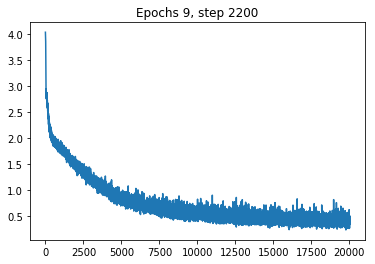

input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward

input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 13, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward

input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 22, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 13, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 24, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward

output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch

output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 24, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 22, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 19, 56])
input
output in seq2seq forward torch

output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 16, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 14, 56])
input
output in seq2seq forward torch.Size([32, 17, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 18, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 21, 56])
input
output in seq2seq forward torch.Size([32, 20, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 15, 56])
input
output in seq2seq forward torch.Size([32, 22, 56])
input
output in seq2seq forward torch

In [29]:
N_EPOCHS = 10
CLIP = 1

best_test_loss = float('inf')
train_loss_list = []
for epoch in range(1, N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP, epoch, train_loss_list)
    
    test_loss = evaluate(model, test_dataloader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'checkpoint.pth')
        torch.save(model.encoder.state_dict(), 'checkpoint_enc.pth')
        torch.save(model.decoder.state_dict(), 'checkpoint_dec.pth')
    
    generations = generate_transcriptions(model, w_vocab, t_vocab, 'apple')
    
    print(generations)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. PPL: {math.exp(test_loss):7.3f}')

In [30]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS)

In [31]:
class Generator(object):
    def __init__(self):
        self.encoder = enc
        self.encoder.load_state_dict(torch.load('checkpoint_enc.pth'))
        self.decoder = dec
        self.decoder.load_state_dict(torch.load('checkpoint_dec.pth'))
        self.model = model
        self.model.load_state_dict(torch.load('checkpoint.pth'))
        self.w_vocab = w_vocab
        self.t_vocab = t_vocab
        
    def generate_transcriptions(self, word):
        
        self.model.eval()
        word_tokenized = tokenize(word)
        word_tokenized = [w.upper() for w in word_tokenized]
        word_indexed = [w_vocab.token2idx(w) for w in word_tokenized]
        word_indexed = torch.LongTensor(word_indexed).to(device)
      
        outputs = model.predict(word_indexed)
        transcriptions = [t_vocab.idx2token(t) for t in outputs]
        return outputs

In [32]:
g = Generator()

In [33]:
t = g.generate_transcriptions('bottle')

In [34]:
tr = []
for i in t:
    j = t_vocab.idx2token(i)
    tr.append(j.lower())

In [35]:
tr

['b', 'a', 'a', 't', 'a', 'h', 'l']